[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
# AS05 Suggested Solutions 

Assignment Designer: Ji-Lung, Hsieh

## AS05-1 Getting ibon store address
* 這題的目標是取得所有ibon生活便利站的所在地址。http://www.ibon.com.tw/retail_inquiry.aspx#gsc.tab=0。
* 我已經幫你寫好，怎麼從上述網頁取得所有縣市名稱（`get()` + `BeautifulSoup`如**Get all counties***）。我也幫你寫好，怎麼取得某一個縣市的所有生活便利站（`post()` + `BeautifulSoup` 如**Get stores of a county**）。

In [1]:
# 這邊不用動
# 如果未下載過user_agent，可以移除下面這一行的註解並執行安裝；執行一次就好
# !pip install user_agent
import pandas as pd
import requests
from bs4 import BeautifulSoup
from user_agent import generate_user_agent

In [2]:
# 這邊也不用動，先幫你跑完縣市名稱
user_agent = generate_user_agent()
headers = {'user_agent': user_agent}

url_counties = 'http://www.ibon.com.tw/retail_inquiry.aspx#gsc.tab=0'
res = requests.get(url_counties, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

counties = []
for item in soup.select("#Class1 option"):
    counties.append(item.text)

counties

['台北市',
 '新北市',
 '基隆市',
 '宜蘭縣',
 '桃園市',
 '新竹市',
 '新竹縣',
 '苗栗縣',
 '台中市',
 '彰化縣',
 '南投縣',
 '雲林縣',
 '嘉義市',
 '嘉義縣',
 '台南市',
 '高雄市',
 '屏東縣',
 '花蓮縣',
 '台東縣',
 '澎湖縣',
 '金門縣',
 '連江縣',
 '南海諸島']

### Solution 1

In [3]:
user_agent = generate_user_agent()
headers = {'user_agent': user_agent}

url_ibon = 'http://www.ibon.com.tw/retail_inquiry_ajax.aspx'
cname = ['sid', 'sname', 'addr']

rows = []
for i in counties:
    payloads = {'strTargetField':'COUNTY',
                'strKeyWords': i }
    
    raw = requests.post(url_ibon, headers=headers, data=payloads)
    soup = BeautifulSoup(raw.text, 'html.parser')
    table_rows = soup.find('table').find_all('tr')
    
    for tr in table_rows[1:]:
        tds = tr.find_all('td')
        
        row = []
        for td in tds:
            row.append(td.text.strip())
        rows.append(row)
    
pd.DataFrame(rows, columns=cname)

,sid,sname,addr
0,110817,千翔,台北市中正區許昌街17號1樓
1,111278,前港,台北市士林區後港街98之1號2號1樓
2,111636,江東,台北市中山區長安東路二段43號45-1號1樓
3,112684,塔優,台北市松山區撫遠街197號199號
4,113089,秀湖,台北市內湖區成功路四段359號1樓
...,...,...,...
6165,950376,南竿,連江縣南竿鄉清水村100號
6166,952512,馬港,連江縣南竿鄉馬祖村中山路58號60號
6167,952523,北竿,連江縣北竿鄉塘岐村中山路193號195號
6168,991322,中隴,連江縣南竿鄉介壽村3鄰48-2號


### Solution 2
使用`pandas`的`read_html`function

In [4]:
user_agent = generate_user_agent()
headers = {'user_agent': user_agent}

url_ibon = 'http://www.ibon.com.tw/retail_inquiry_ajax.aspx'

data = []
for i in counties:
    payloads = {'strTargetField':'COUNTY',
                'strKeyWords': i }
    raw = requests.post(url_ibon, headers=headers, data=payloads)
    soup = BeautifulSoup(raw.text, 'html.parser')
    df = pd.read_html(str(soup), flavor="bs4")[0]
    df["county"] = i
    df = df[1:]
    data.append(df)
    
df_data = pd.concat(data)
df_data.columns = ['sid', 'sname', 'addr', 'county']

df_data

,sid,sname,addr,county
1,110817,千翔,台北市中正區許昌街17號1樓,台北市
2,111278,前港,台北市士林區後港街98之1號2號1樓,台北市
3,111636,江東,台北市中山區長安東路二段43號45-1號1樓,台北市
4,112684,塔優,台北市松山區撫遠街197號199號,台北市
5,113089,秀湖,台北市內湖區成功路四段359號1樓,台北市
...,...,...,...,...
9,950376,南竿,連江縣南竿鄉清水村100號,連江縣
10,952512,馬港,連江縣南竿鄉馬祖村中山路58號60號,連江縣
11,952523,北竿,連江縣北竿鄉塘岐村中山路193號195號,連江縣
12,991322,中隴,連江縣南竿鄉介壽村3鄰48-2號,連江縣


## AS05_2 Scraping PTT comments
- 撈取Boy-Girl版最新的10頁文章（並非10則文章，是10頁的文章，約150則左右）。
- 撈取的同時，請稍微修改下面的Code以抓回Comments

In [5]:
# 這邊不用動
# 如果未下載過user_agent，可以移除下面這一行的註解並執行安裝；執行一次就好
# !pip install user_agent
import requests
from user_agent import generate_user_agent
import pandas as pd
from bs4 import BeautifulSoup
from bs4 import NavigableString

In [2]:
# 這邊也不用動，先幫大家把網址抓完

user_agent = generate_user_agent()
headers = {'user_agent': user_agent}

pre = 'https://www.ptt.cc'
lastpage = 5303

links = []
for i in range(lastpage, lastpage-10, -1):
    url = 'https://www.ptt.cc/bbs/Boy-Girl/index{}.html'.format(i)
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    for div in soup.find_all(class_='r-ent'):
        try:
            links.append(pre + div.find(class_='title').a['href'])
        except:
            pass
    print(i, "\t", len(links))

5303 	 20
5302 	 40
5301 	 60
5300 	 80
5299 	 100
5298 	 120
5297 	 140
5296 	 160
5295 	 180
5294 	 200


### Solution

In [3]:
user_agent = generate_user_agent()
headers = {'user_agent': user_agent}

all_post = []
for link in links:
    print(link)
    temp = {}

    res = requests.get(link, headers=headers)
    soup = BeautifulSoup(res.text, 'html.parser')

    temp['author'] = soup('span', class_='article-meta-value')[0].get_text()
    temp['link'] = link
    temp['title'] = soup('span', class_='article-meta-value')[-2].get_text()
    temp['timestamp'] = soup('span', class_='article-meta-value')[-1].get_text()
    
    content = [str(element).strip() for element in soup.find('div', id='main-content') if isinstance(element, NavigableString)]
    # content = '\n'.join([item for c in content for item in c.split('\n')])
    temp['content'] = content[0]

    comments = []
    for push in soup.find_all(class_='push'):
        push_tag = push.find(class_='push-tag').text
        push_userid = push.find(class_='push-userid').text
        push_content = push.find(class_='push-content').text
        push_ipdatetime = push.find(class_='push-ipdatetime').text

        #print push_userid, push_content, push_ipdatetime
        comments.append({'tag': push_tag,
                         'userid':push_userid, 
                         'content':push_content, 
                         'timestamp':push_ipdatetime})

    temp['comments'] = comments
    all_post.append(temp)  

https://www.ptt.cc/bbs/Boy-Girl/M.1618342063.A.F2B.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618344834.A.66A.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618359851.A.067.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618360092.A.DF1.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618362227.A.EF9.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618364360.A.939.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618368677.A.89A.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618373248.A.367.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618380717.A.1A7.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618381033.A.C5D.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618385691.A.57D.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618391242.A.C72.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618395186.A.017.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618398224.A.B58.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618399194.A.9D5.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618404764.A.8DA.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618410678.A.654.html
https://www.ptt.cc/bbs/Boy-Girl/M.1618414958.A.7

https://www.ptt.cc/bbs/Boy-Girl/M.1617714737.A.192.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617722872.A.36F.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617723339.A.5F8.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617726457.A.483.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617729499.A.19C.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617743374.A.526.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617744337.A.FE1.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617760896.A.319.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617762110.A.21E.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617778263.A.0D4.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617781509.A.D23.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617781865.A.300.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617782587.A.CF2.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617637524.A.16A.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617644370.A.515.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617644480.A.3F2.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617648545.A.85F.html
https://www.ptt.cc/bbs/Boy-Girl/M.1617649989.A.4

In [6]:
df_ptt = pd.DataFrame(all_post)
unnest = df_ptt.explode('comments')

unnest

,author,link,title,timestamp,content,comments
0,a27568708a (Mclaren765lt),https://www.ptt.cc/bbs/Boy-Girl/M.1618342063.A...,[討論] 跟女友讀不同校 晚上回宿舍危險怎麼辦,Wed Apr 14 03:27:39 2021,7月要升碩班了，女友在台大，我在交大，他們實驗室做實驗通常都會做很晚，我們實驗室也是，所以沒...,"{'tag': '推 ', 'userid': 'Nigger5566', 'content..."
0,a27568708a (Mclaren765lt),https://www.ptt.cc/bbs/Boy-Girl/M.1618342063.A...,[討論] 跟女友讀不同校 晚上回宿舍危險怎麼辦,Wed Apr 14 03:27:39 2021,7月要升碩班了，女友在台大，我在交大，他們實驗室做實驗通常都會做很晚，我們實驗室也是，所以沒...,"{'tag': '推 ', 'userid': 'marktak', 'content': ..."
0,a27568708a (Mclaren765lt),https://www.ptt.cc/bbs/Boy-Girl/M.1618342063.A...,[討論] 跟女友讀不同校 晚上回宿舍危險怎麼辦,Wed Apr 14 03:27:39 2021,7月要升碩班了，女友在台大，我在交大，他們實驗室做實驗通常都會做很晚，我們實驗室也是，所以沒...,"{'tag': '推 ', 'userid': 'HenryLin123', 'conten..."
0,a27568708a (Mclaren765lt),https://www.ptt.cc/bbs/Boy-Girl/M.1618342063.A...,[討論] 跟女友讀不同校 晚上回宿舍危險怎麼辦,Wed Apr 14 03:27:39 2021,7月要升碩班了，女友在台大，我在交大，他們實驗室做實驗通常都會做很晚，我們實驗室也是，所以沒...,"{'tag': '推 ', 'userid': 'marsonele', 'content'..."
0,a27568708a (Mclaren765lt),https://www.ptt.cc/bbs/Boy-Girl/M.1618342063.A...,[討論] 跟女友讀不同校 晚上回宿舍危險怎麼辦,Wed Apr 14 03:27:39 2021,7月要升碩班了，女友在台大，我在交大，他們實驗室做實驗通常都會做很晚，我們實驗室也是，所以沒...,"{'tag': '噓 ', 'userid': 'wawi2', 'content': ':..."
...,...,...,...,...,...,...
198,breath35 ( 慨之巨人),https://www.ptt.cc/bbs/Boy-Girl/M.1617637019.A...,Re: [心情] 明理的基督徒女友說不想浪費時間,Mon Apr 5 23:36:57 2021,這系列看到已經有幾位是基督徒弟兄回文了，不過對這案例本魯叔\n覺得需要幫你們把感情障礙分析得...,"{'tag': '推 ', 'userid': 'kkbaby', 'content': '..."
198,breath35 ( 慨之巨人),https://www.ptt.cc/bbs/Boy-Girl/M.1617637019.A...,Re: [心情] 明理的基督徒女友說不想浪費時間,Mon Apr 5 23:36:57 2021,這系列看到已經有幾位是基督徒弟兄回文了，不過對這案例本魯叔\n覺得需要幫你們把感情障礙分析得...,"{'tag': '→ ', 'userid': 'smallplug', 'content'..."
198,breath35 ( 慨之巨人),https://www.ptt.cc/bbs/Boy-Girl/M.1617637019.A...,Re: [心情] 明理的基督徒女友說不想浪費時間,Mon Apr 5 23:36:57 2021,這系列看到已經有幾位是基督徒弟兄回文了，不過對這案例本魯叔\n覺得需要幫你們把感情障礙分析得...,"{'tag': '推 ', 'userid': 'scorpio8018', 'conten..."
199,YAYA6655 (YAYA),https://www.ptt.cc/bbs/Boy-Girl/M.1617637025.A...,Re: [分享] 交到另一半最重要的是把自己準備好,Mon Apr 5 23:37:03 2021,,"{'tag': '推 ', 'userid': 'k268185', 'content': ..."


## AS05_3 News crawler
挑選apple daily news、udn online news或ltn online news任一家，這三家線上新聞的「搜尋頁面」其搜尋結果都是用JSON傳回前端，請挑選一則新聞撰寫爬蟲，撰寫完後轉為pandas，並列印出該pandas的shape。新聞數應不少於100則。


### Apple Daily

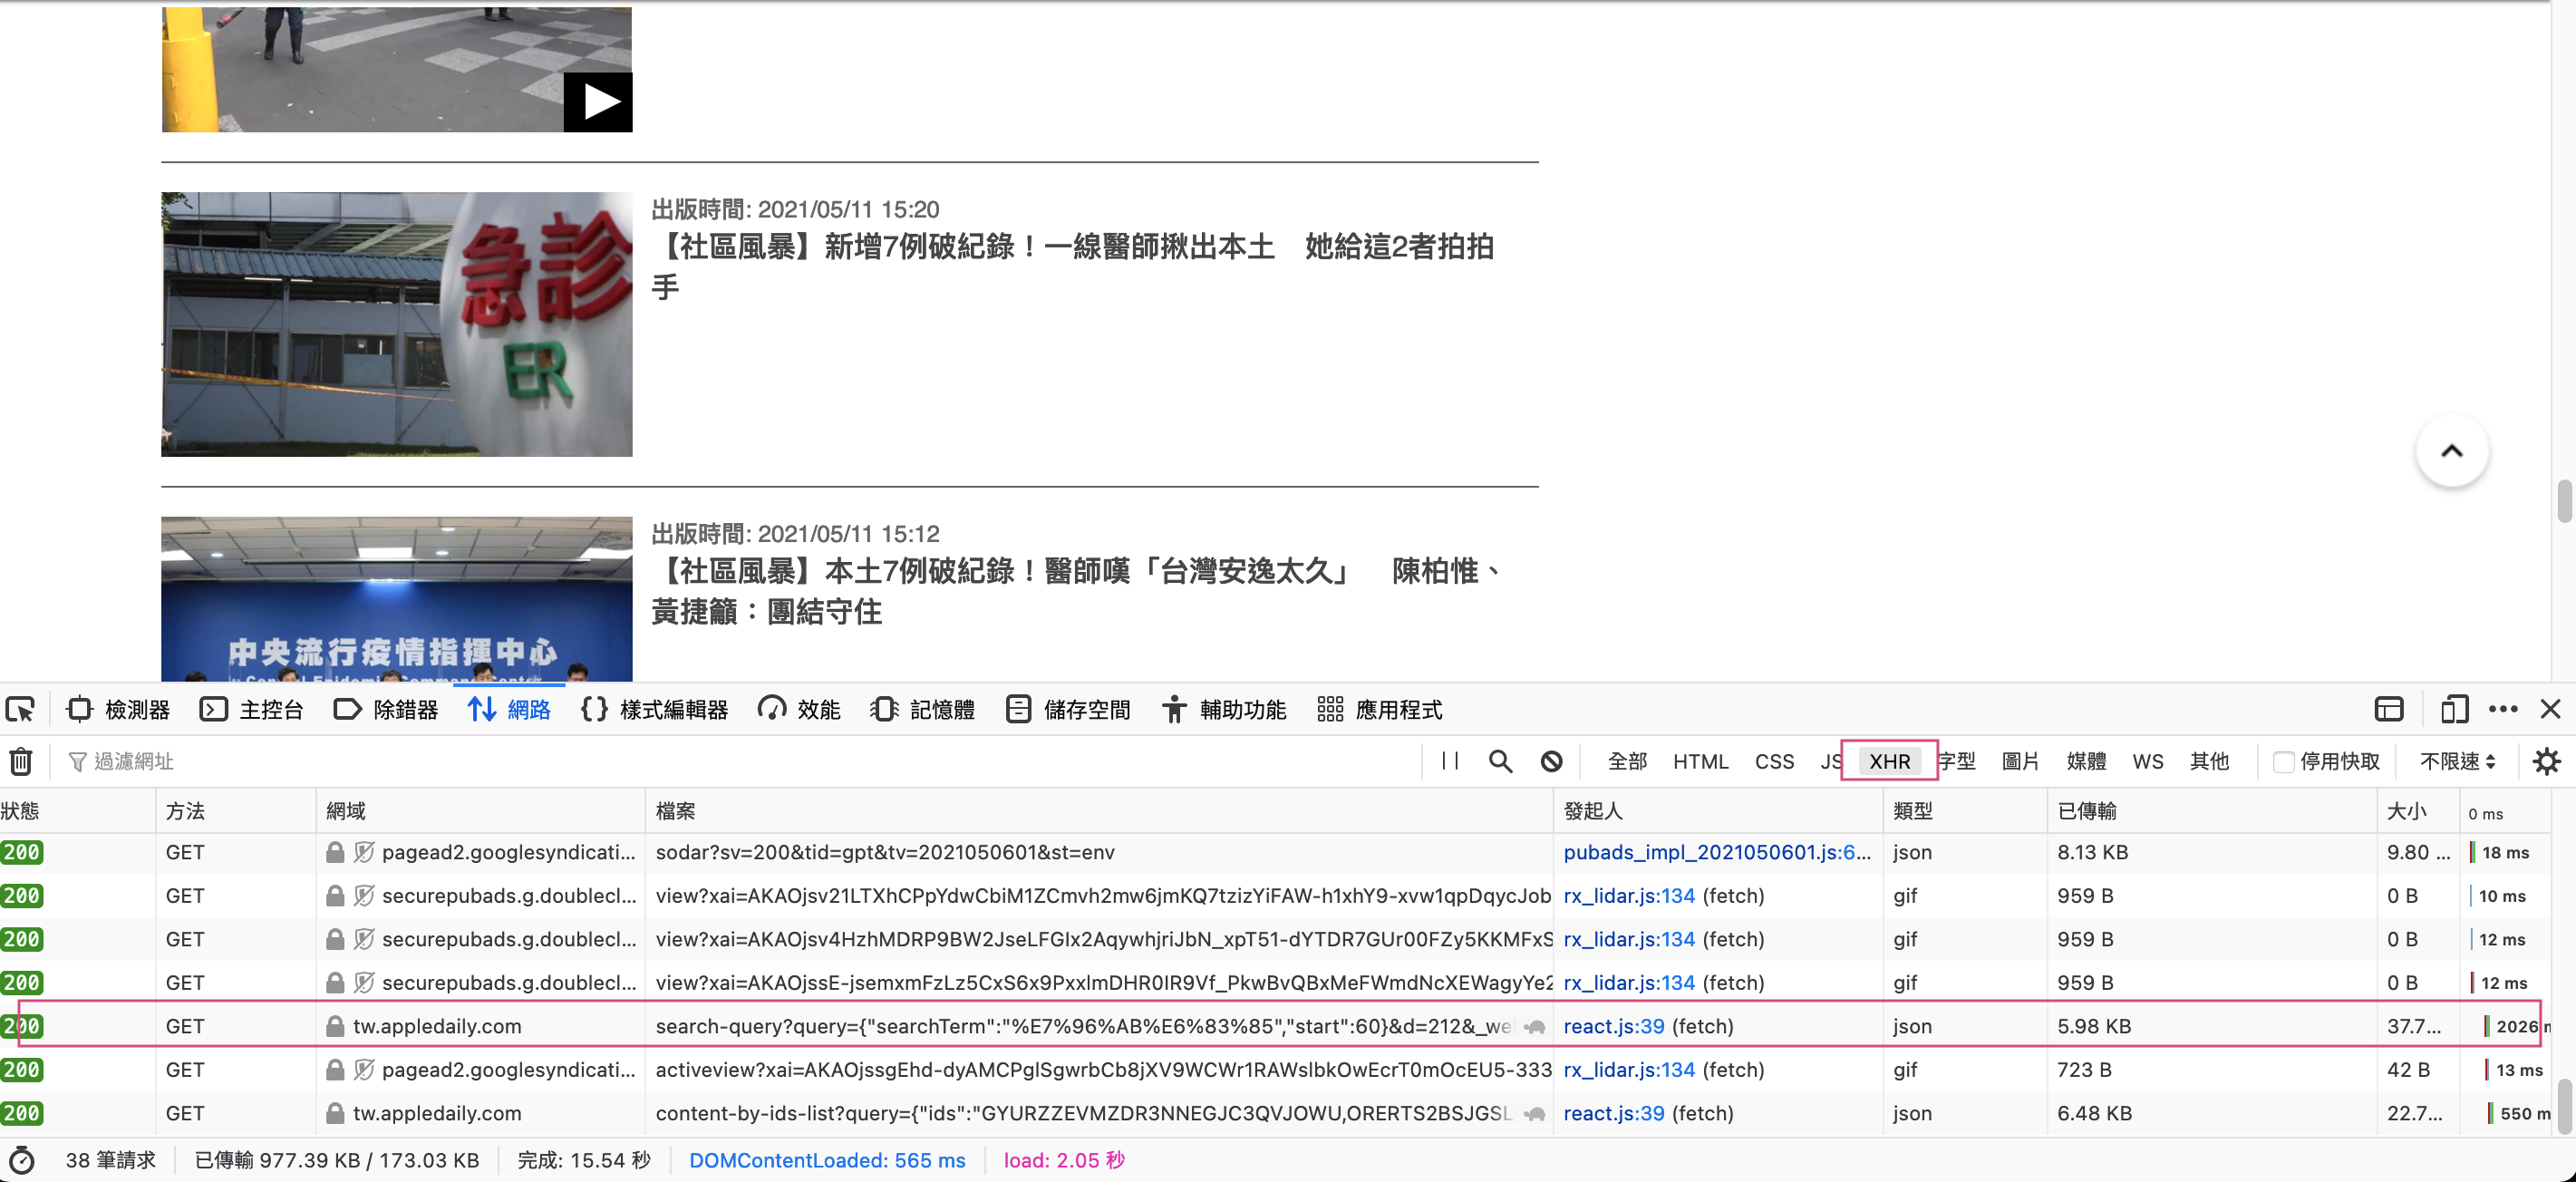

In [1]:
# !pip install user_agent
import pandas as pd
import requests
from user_agent import generate_user_agent

In [2]:
user_agent = generate_user_agent()
headers = {'user_agent': user_agent}

kw = '疫情'

data_apple = []
for i in range(0, 120, 20):
    start_index = i
    
    if i == 0:
        query = '"searchTerm":"{}"'.format(kw)
    else:
        query = '"searchTerm":"{}","start":{}'.format(kw, i)
    
    url = 'https://tw.appledaily.com/pf/api/v3/content/fetch/search-query?query={' + query + '}&_website=tw-appledaily'
#     print(url)
    res = requests.get(url, headers=headers).json()
    items = res["content"]
    for item in items:
#         print(item)
        data_apple.append(item)

df_apple = pd.DataFrame(data_apple)
print(df_apple.shape)

(120, 31)


In [3]:
data_apple[0]

{'order': '1',
 '_id': 'Q3ACI574UFG7LKKZ3JRZJAOCTI',
 'highlight': '0',
 'brandId': '1',
 'brandName': '蘋果日報',
 'brandArticleId': 'Q3ACI574UFG7LKKZ3JRZJAOCTI',
 'brandCategoryId': '/1/5004',
 'brandCategoryName': '娛樂時尚',
 'mlCategoryId': '',
 'mlArticleId': 'Q3ACI574UFG7LKKZ3JRZJAOCTI',
 'issueId': '20210511',
 'pubDate': '1620724330',
 'updateDate': '1620724340',
 'displayLayoutPreset': 'BIG_IMAGE_WITH_TEXT',
 'displayTime': '1620724330',
 'forceToShowDate': 'false',
 'title': '魏如萱把自己當孩子跟著兒子哭\u3000明金曲入圍壓寶Hebe韋禮安',
 'description': '',
 'label': '娛樂時尚即時',
 'mediaGroup': [{'type': 'image',
   'smallPath': 'https://hk.appledaily.com/resizer/lMofxmOghme0P17KaJMw0xaXS6g=/filters:quality(100)/d87urpdhi5rdo.cloudfront.net/05-11-2021/t_2f41f6faac194294847cd753cd70afb9_name_ADSP5505.JPG',
   'largePath': 'https://hk.appledaily.com/resizer/lMofxmOghme0P17KaJMw0xaXS6g=/filters:quality(100)/d87urpdhi5rdo.cloudfront.net/05-11-2021/t_2f41f6faac194294847cd753cd70afb9_name_ADSP5505.JPG',
   'width': '

### UDN Online 

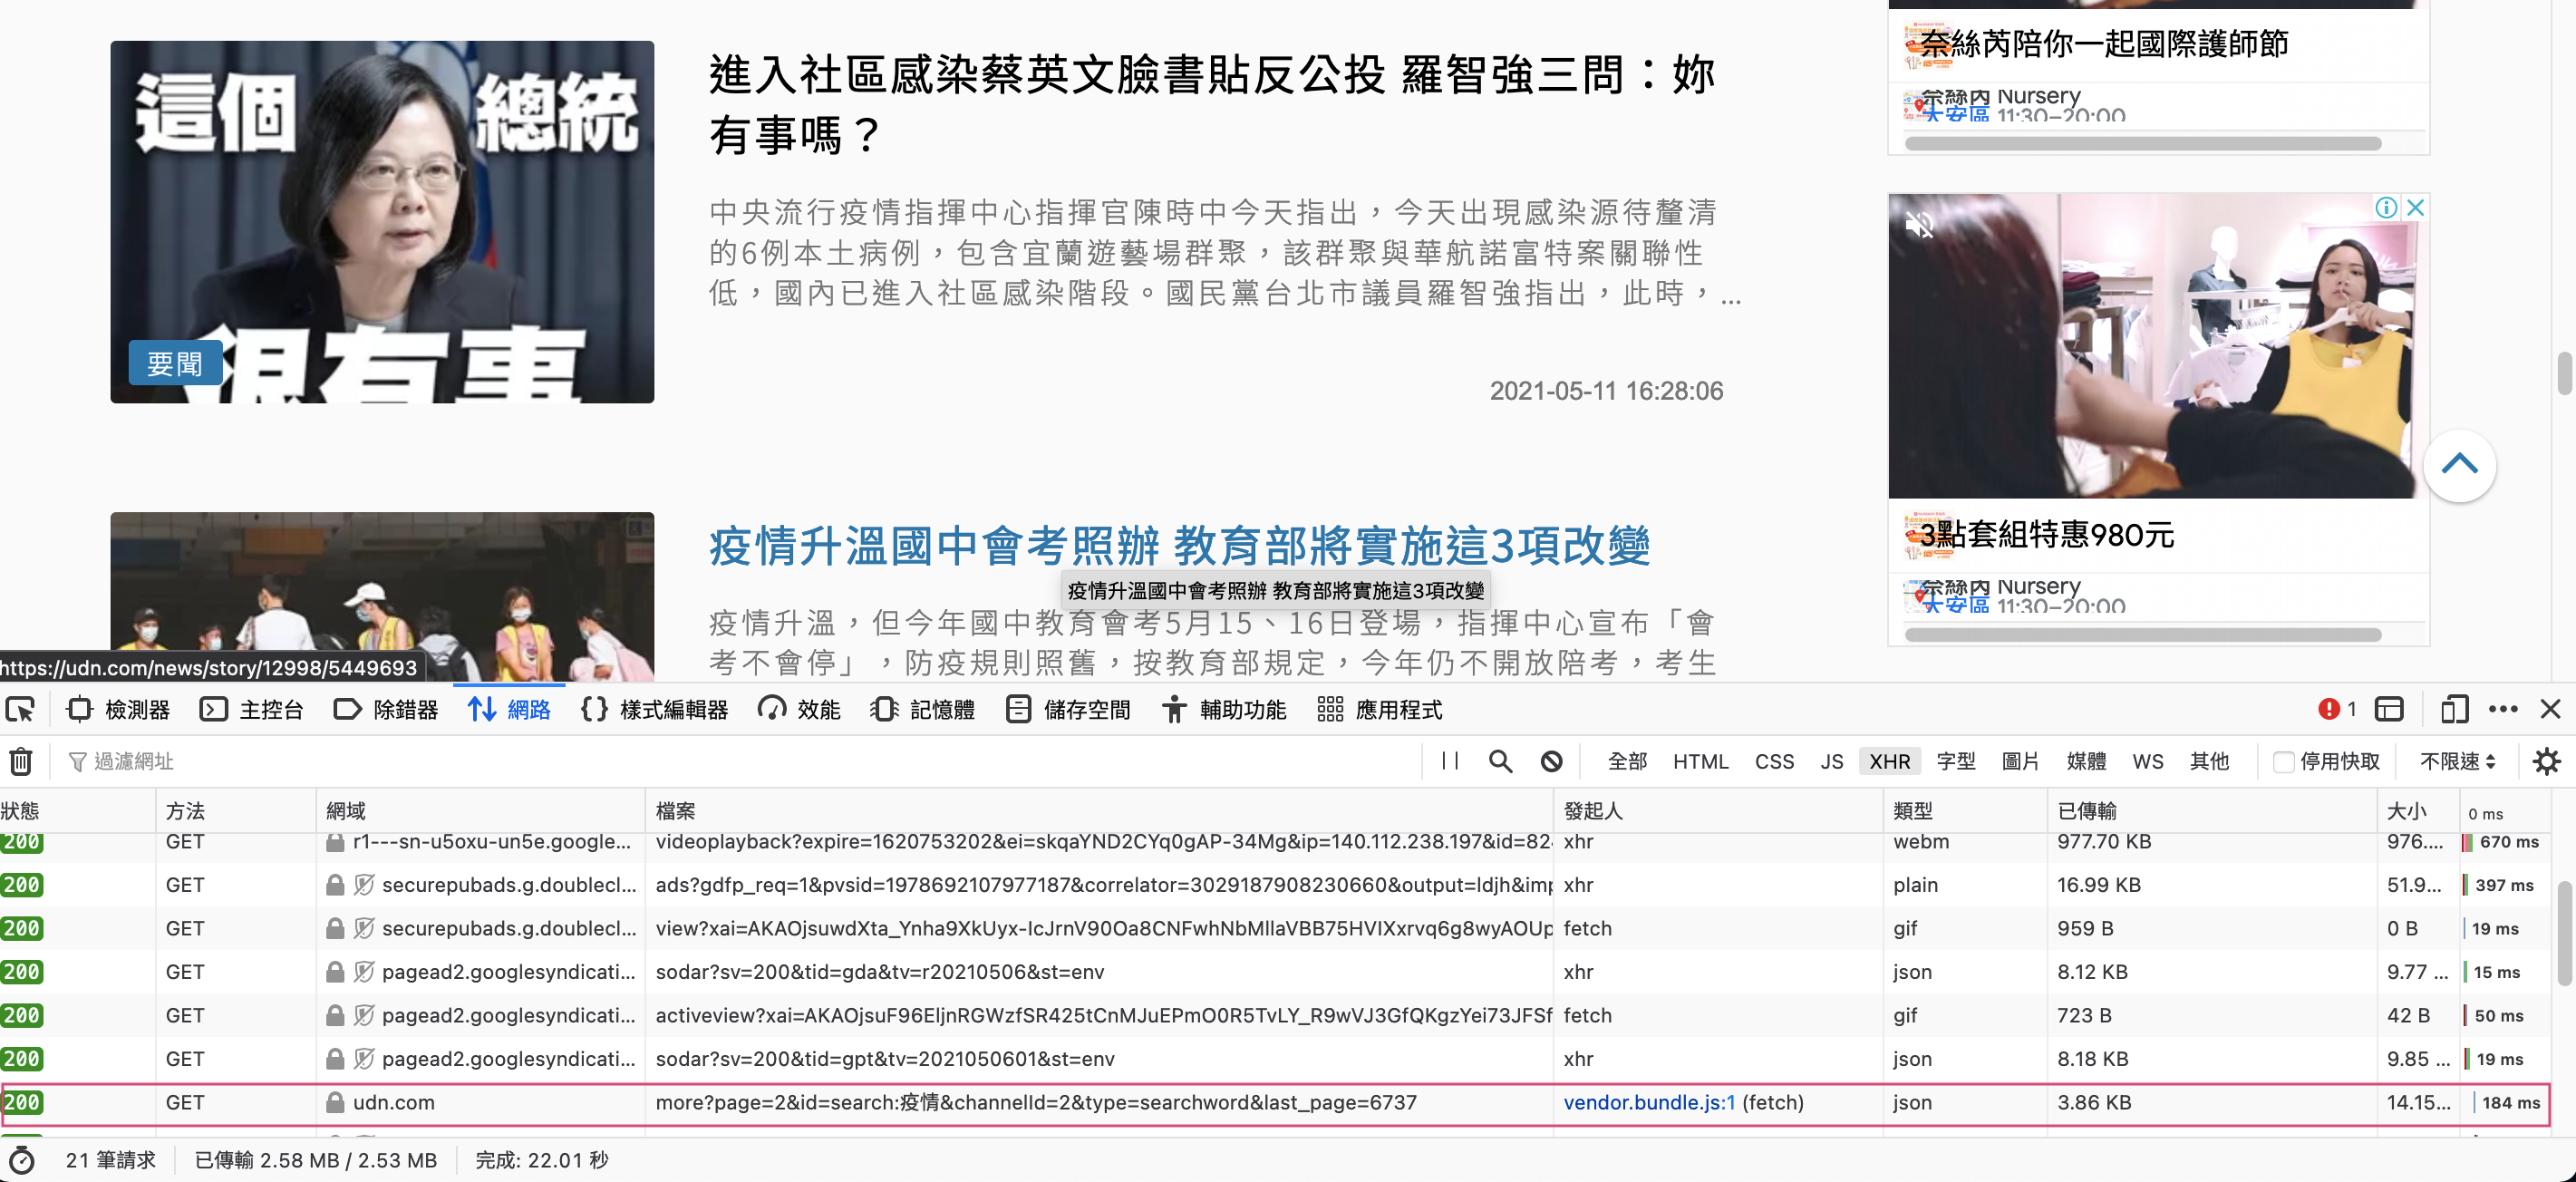

In [4]:
# !pip install user_agent
import pandas as pd
import requests
from user_agent import generate_user_agent

In [5]:
user_agent = generate_user_agent()
headers = {'user_agent': user_agent}

kw = '疫情'

data_udn = []
for i in range(1, 12):
    
    start_index = i
    
    url = 'https://udn.com/api/more?page={}&id=search:{}&channelId=2&type=searchword'.format(i, kw)
    print(url)
    res = requests.get(url, headers=headers).json()
    items = res['lists']
    for item in items:
#         print(item)
        data_udn.append(item)

df_udn = pd.DataFrame(data_udn)
print(df_udn.shape)

https://udn.com/api/more?page=1&id=search:疫情&channelId=2&type=searchword
https://udn.com/api/more?page=2&id=search:疫情&channelId=2&type=searchword
https://udn.com/api/more?page=3&id=search:疫情&channelId=2&type=searchword
https://udn.com/api/more?page=4&id=search:疫情&channelId=2&type=searchword
https://udn.com/api/more?page=5&id=search:疫情&channelId=2&type=searchword
https://udn.com/api/more?page=6&id=search:疫情&channelId=2&type=searchword
https://udn.com/api/more?page=7&id=search:疫情&channelId=2&type=searchword
https://udn.com/api/more?page=8&id=search:疫情&channelId=2&type=searchword
https://udn.com/api/more?page=9&id=search:疫情&channelId=2&type=searchword
https://udn.com/api/more?page=10&id=search:疫情&channelId=2&type=searchword
https://udn.com/api/more?page=11&id=search:疫情&channelId=2&type=searchword
(220, 7)


In [6]:
data_udn[0]

{'url': 'https://pgw.udn.com.tw/gw/photo.php?u=https://uc.udn.com.tw/photo/2021/05/11/realtime/12267768.png&s=Y&x=0&y=9&sw=1279&sh=852&exp=3600',
 'titleLink': 'https://udn.com/news/story/7266/5449791',
 'title': '澎湖防疫升級！賴峰偉：花火節6月8日前場次暫停',
 'paragraph': '國內出現感染源不明本土確診案例，澎湖縣防疫升級，縣長賴峰偉今天在防疫會議宣布配合防疫規定，暫停6月8日前澎湖國際海上花火節活動，剩餘場次視疫情狀況，延至6月8日後舉行；另停辦端午節龍舟賽、社區關懷據...',
 'cateLink': 'https://udn.com/news/cate/6649',
 'cateTitle': '生活',
 'time': {'dateTime': '2021-05-11 17:10:13', 'date': '2021-05-11 17:10:13'}}

### LTN Online

In [7]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from user_agent import generate_user_agent

In [8]:
kw = '疫情'
start_time = '20041201'
end_time = '20210511'

user_agent = generate_user_agent()
headers = {'user_agent': user_agent}


data_ltn = []
for i in range(1, 13):
    url = 'https://search.ltn.com.tw/list?keyword={}&start_time={}&end_time={}&sort=date&type=all&page={}'.format(kw, start_time, end_time, i)
#     print(url)
    res = requests.get(url, headers=headers)
    soup = BeautifulSoup(res.text, 'html.parser')
    soup = soup.find('ul', class_='list')
    
    result = {}
    lis = soup.find_all('li')  
    for li in lis:
        result['title'] = li.a['title']
        result['href'] = li.a['href']
        data_ltn.append(result)

df_ltn = pd.DataFrame(data_ltn)
print(df_ltn.shape)

(240, 2)


In [9]:
data_ltn[0]

{'title': '防疫升級 教育部：全大運及國中會考增消毒設備與頻率  ',
 'href': 'https://news.ltn.com.tw/news/life/breakingnews/3528269'}